<a href="https://colab.research.google.com/github/Xixianghu202124213/Capstone/blob/main/ARIMA_no_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF
import numpy as np
%matplotlib inline
import csv
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


           MATERIAL_NUMBER PLANT  QUANTITY
DATE                                      
2015-01-05               H    X2         0
2015-01-06               H    X2         5
2015-01-07               H    X2         2
2015-01-08               H    X2       260
2015-01-09               H    X2         9
...                    ...   ...       ...
2020-01-01               H    X2         0
2020-01-02               H    X2        33
2020-01-03               H    X2        27
2020-01-04               H    X2         0
2020-01-05               H    X2         0

[1827 rows x 3 columns]


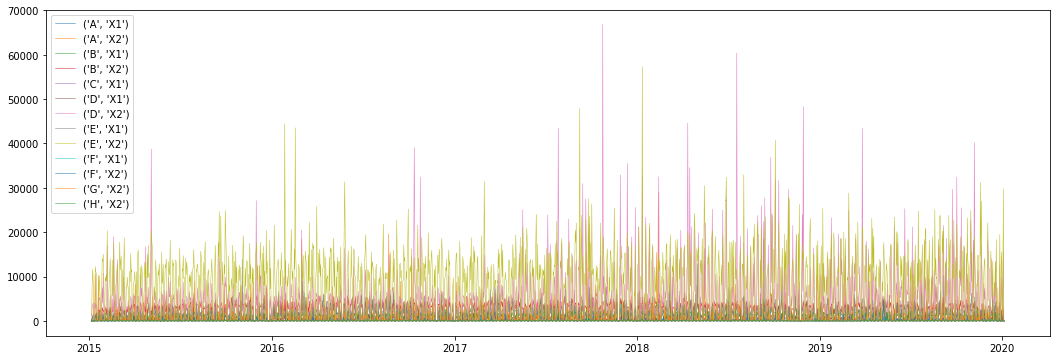

In [2]:

csvfile = open('/content/drive/MyDrive/Data/historical_orders.csv','r')
reader = [each for each in csv.DictReader(csvfile, delimiter=';')]
df = pd.DataFrame(reader)

df["DATE"]=pd.to_datetime(df["DATE"],format="%d.%m.%Y")
df.set_index('DATE',inplace=True)
groups=df.groupby(["MATERIAL_NUMBER","PLANT"])
group_list=list(groups)
group_list
from pandas import DataFrame
ax,fig=plt.subplots(figsize=(18,6))
series=DataFrame()
for key,df in groups:
    series=df.copy()
    series.iloc[:,2]=series.iloc[:,2].astype(int)
    plt.plot(series.index,series.iloc[:,2],linewidth=0.5,label=key)
    plt.legend()
   # print(type(df))
print(series)


#train model

In [32]:
from sklearn.metrics import mean_squared_error, r2_score
def ARIMA_Model(timeseries, order):
    model = ARIMA(timeseries, order=order)
    return model.fit(disp=0)

In [33]:
def log(timeseries):
  timeseries_log=np.log(timeseries).replace(float("-inf"), 0)
  return timeseries_log

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model_method2(timeseries, arima_order):
  train_size = int(len(timeseries)*0.9)
  train, test = timeseries[0:train_size],timeseries[train_size:]
  rmse=float("inf")
  try:

    model = ARIMA_Model(train,arima_order)
    fit_seq = model.fittedvalues
    rmse = mean_squared_error(train, fit_seq,squared=False)
  except:
    pass
  return rmse

In [6]:
def gridsearch_MA(timeseries):
  series_pdq=[]
  series_mse=[]
  train_size=int(len(timeseries)*0.9)
  train=timeseries[0:train_size]
  test=timeseries[train_size:]
  best_score = float("inf")

  for q in range(8):  
    order=(0,0,q)
    #print(str(order))
    try:
      rmse=evaluate_model_method2(timeseries,order)
      if rmse<best_score:
        
        best_score=rmse
        best_pdq=order
        print("RMSE",best_pdq,best_score)
    except:
        pass
  return best_pdq

In [7]:
def gridsearch(timeseries):
  series_pdq=[]
  series_mse=[]
  train_size=int(len(timeseries)*0.9)
  train=timeseries[0:train_size]
  test=timeseries[train_size:]
  best_score = float("inf")
  best_pdq=None
  for p in range(8):
    for d in range(3):
        for q in range(8):  
          order=(p,d,q)
          #print(str(order))
          try:
            rmse=evaluate_model_method2(timeseries,order)
            if rmse<best_score:
              
              best_score=rmse
              best_pdq=order
              print("RMSE",best_pdq,best_score)
          except:
              pass
  return best_pdq

In [8]:
def model_fit(seasonal,trend,residual,tr_pdq,re_pdq):
  train_size=int(len(trend)*0.9)
  test=seasonal[train_size:]

  tr_p,tr_d,tr_q=int(tr_pdq[0]),int(tr_pdq[1]),int(tr_pdq[2])
  trend_model = ARIMA_Model(trend[0:train_size],(tr_p,tr_d,tr_q))

  trend_fit_seq = trend_model.fittedvalues

  re_p,re_d,re_q=int(re_pdq[0]),int(re_pdq[1]),int(re_pdq[2])
  residual_model = ARIMA_Model(residual[0:train_size],(re_p,re_d,re_q))
  residual_fit_seq = residual_model.fittedvalues

  fit_seq = pd.Series(seasonal[0:train_size], index=seasonal[0:train_size].index)
  fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
  fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

  trend_predict_seq = trend_model.predict(start='2019-07-07',end='2019-08-07',dynamic=True)
  residual_predict_seq = residual_model.predict(start='2019-07-07',end='2019-08-07',dynamic=True)
  seasonal_predict_seq=seasonal['2018-07-01':'2018-08-01']
  
  seasonal_predict_seq.index = test[0:32].index
  predict_seq = pd.Series(seasonal_predict_seq, index=seasonal_predict_seq.index)
  
  predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
  print(len(predict_seq))
  predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)


  return fit_seq,predict_seq


In [9]:
def pre_month(sequence,title,test,tr_pdq,re_pdq):
  rmse = mean_squared_error(test[0:32], sequence,squared=False)
  wape=WAPE(sequence,test[0:32])
  plt.figure(figsize=(20, 8))
  plt.plot(sequence, color='red', label='predict_seq')
  plt.plot(test[0:32], color='blue', label='test_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  RMSE: %f"%(rmse,))
  plt.suptitle(str(title)+"MONTH")
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/MA/"+str(title)+'_predict(Month).png'
  plt.savefig(name)
  plt.show()
  return rmse,wape


In [10]:
def pre_week(sequence,title,test,tr_pdq,re_pdq):
  rmse = mean_squared_error(test[0:8], sequence,squared=False)
  wape=WAPE(sequence,test[0:8])
  plt.figure(figsize=(20, 8))
  plt.plot(sequence, color='red', label='predict_seq')
  plt.plot(test[0:8], color='blue', label='test_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  RMSE: %f"%(rmse,))
  plt.suptitle(str(title)+"WEEK")
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/MA/"+str(title)+'_predict(week).png'
  plt.savefig(name)
  plt.show()
  return rmse,wape

In [11]:
def fit_plot(sequence,title,train,tr_pdq,re_pdq):
  train_size=int(len(train)*0.9)
  #mae=np.mean(np.abs(sequence.values-train))
  rmse = mean_squared_error(train, sequence,squared=False)
  wape=WAPE(sequence,train)
  plt.figure(figsize=(20, 8))
  plt.plot(sequence[len(sequence)-365:len(sequence)], color='red', label='fit_seq')
  plt.plot(train[len(sequence)-365:len(sequence)], color='blue', label='original_seq')
  plt.legend(loc='best')
  plt.title("Trend Model:"+str(tr_pdq) +" Residual Model: "+str(re_pdq)+"  RMSE: %f"%(rmse,))
  plt.suptitle(title)
  name="/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/MA/"+str(title)+'_month_simulation.png'
  plt.savefig(name)
  plt.show()
  return rmse,wape

In [12]:
def WAPE(fit,seq):
  x=(fit-seq).abs().sum()/(seq.abs().sum())
  return x

In [13]:
def recover(series):
  recover_seq= np.exp(series)
  recover_seq.dropna(inplace=True)
  return recover_seq

RMSE (0, 0, 0) 59.89719589246294
RMSE (0, 0, 1) 42.00930757968903
RMSE (0, 0, 3) 31.232728028024475
RMSE (0, 0, 4) 31.209813720330242
RMSE (0, 0, 5) 30.824676117809105
RMSE (0, 0, 7) 22.70656975394682
RMSE (0, 0, 0) 142.17435789183344
RMSE (0, 0, 1) 118.41245658616782
RMSE (0, 0, 2) 111.89555559864111
32


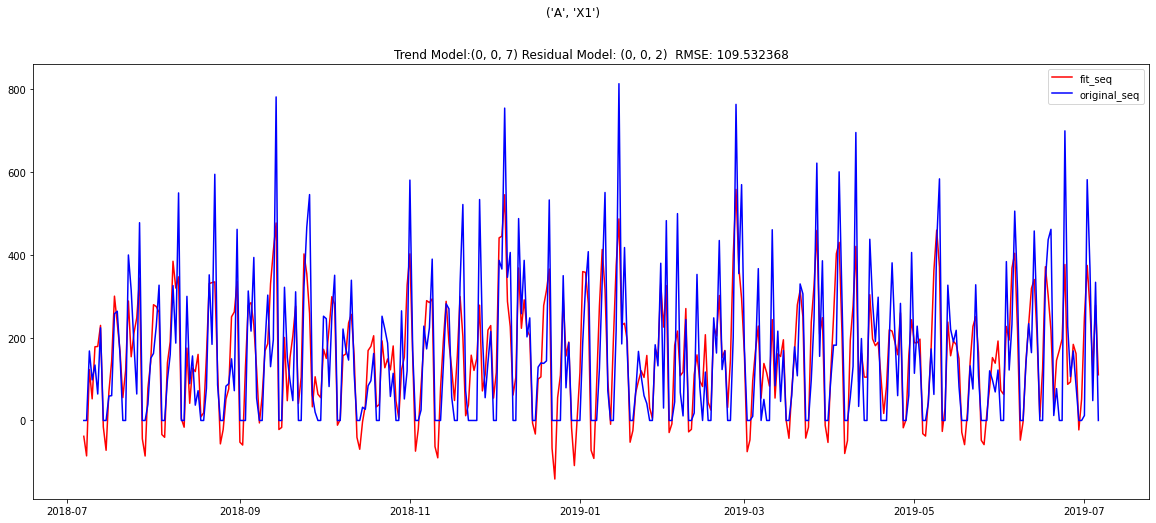

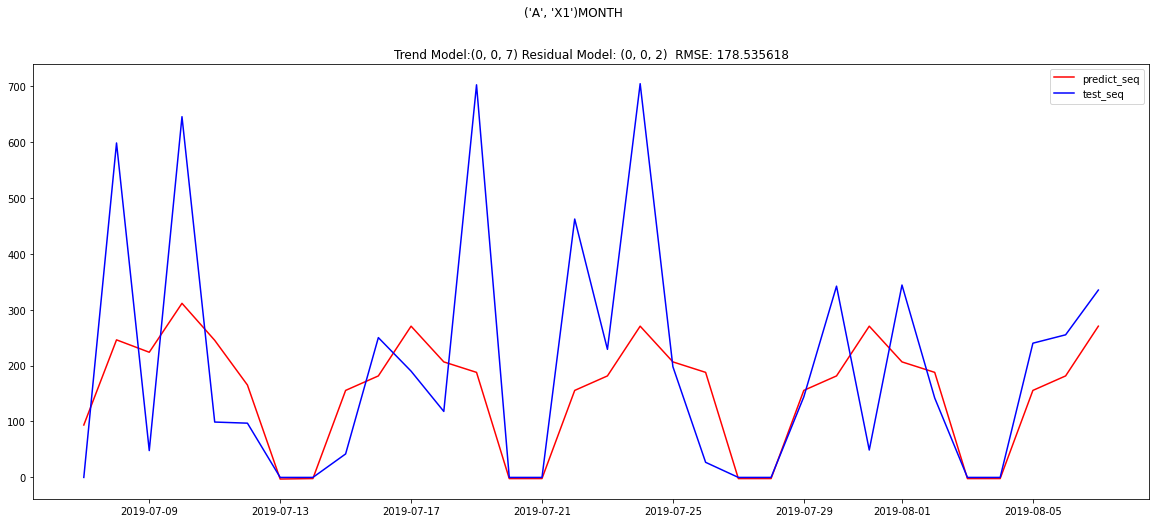

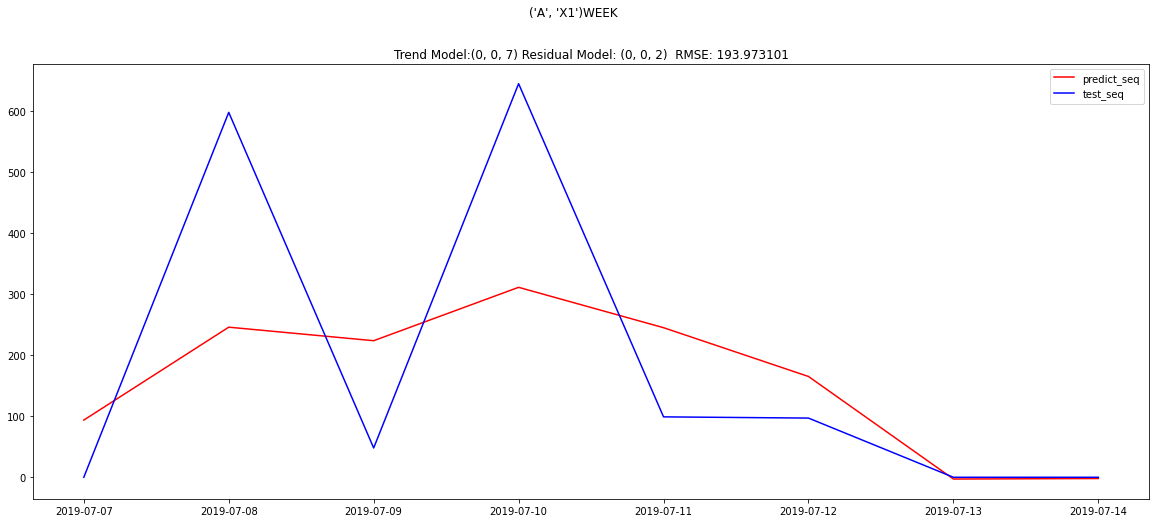

RMSE (0, 0, 0) 632.981180290909
RMSE (0, 0, 1) 432.24753369316437
RMSE (0, 0, 3) 327.87393908719827
RMSE (0, 0, 0) 1435.0660817040748
RMSE (0, 0, 1) 1183.5774883718843
RMSE (0, 0, 2) 1120.0187363616742
32


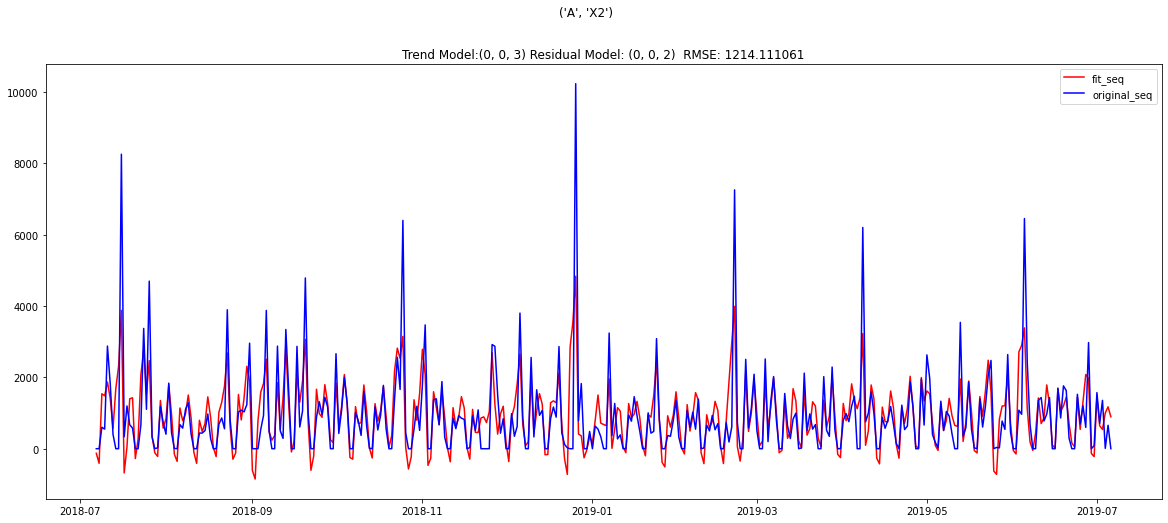

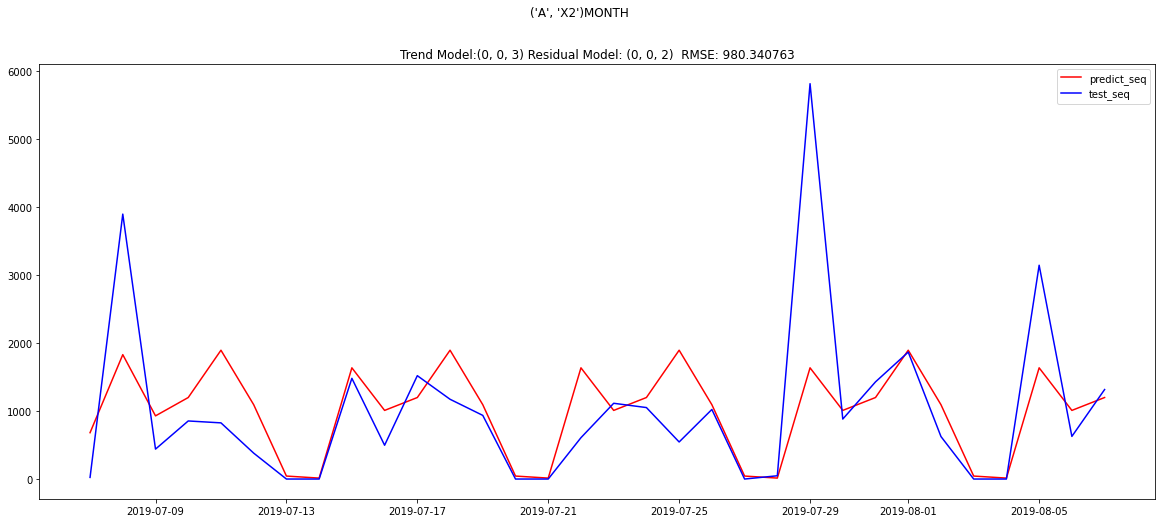

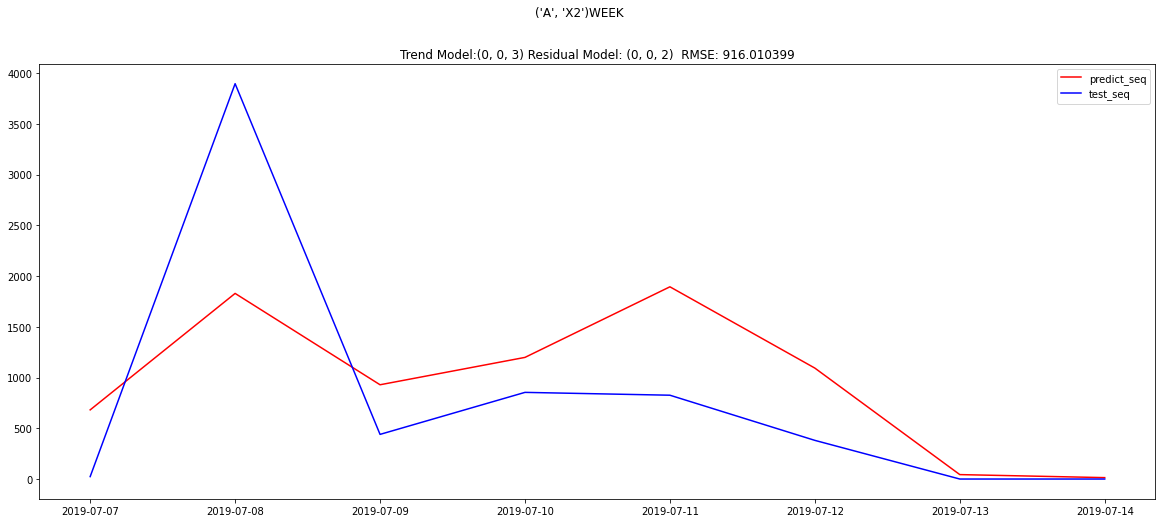

RMSE (0, 0, 0) 321.9532703171589
RMSE (0, 0, 1) 209.9808254572957
RMSE (0, 0, 5) 138.41954515277328
RMSE (0, 0, 0) 605.1250234422037
RMSE (0, 0, 1) 513.5140331026084
RMSE (0, 0, 2) 479.29323900558586
32


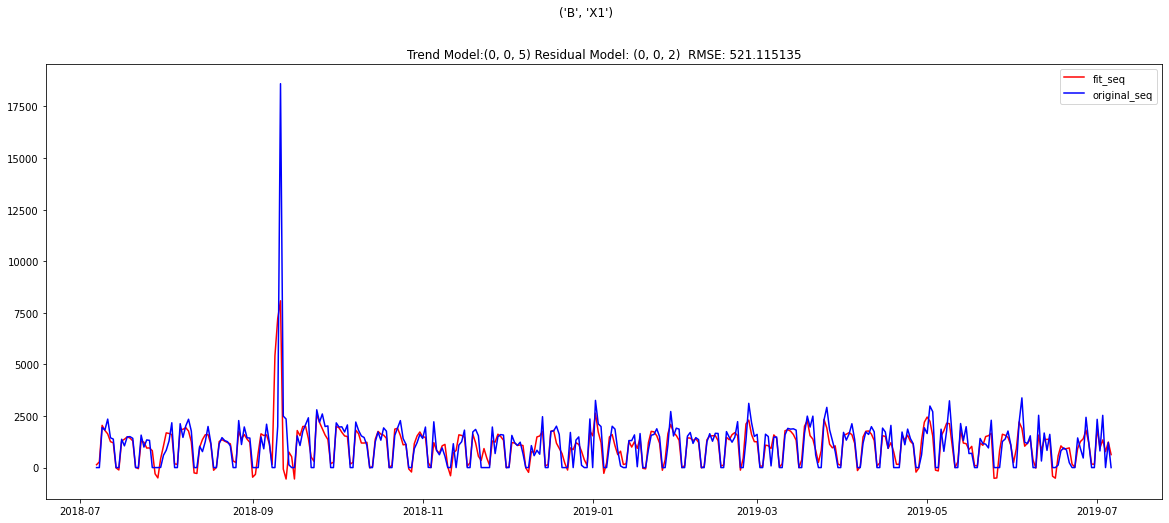

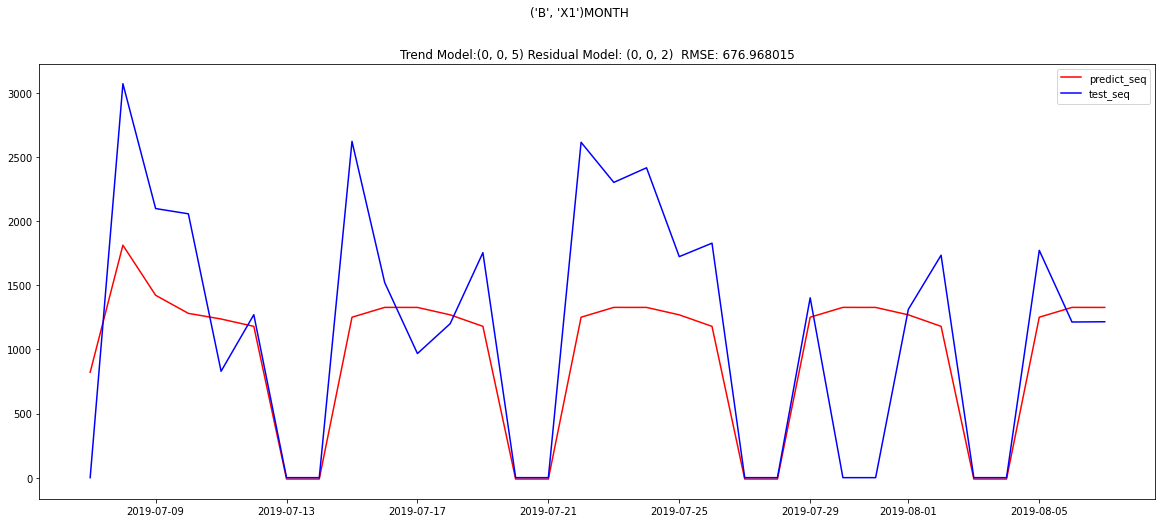

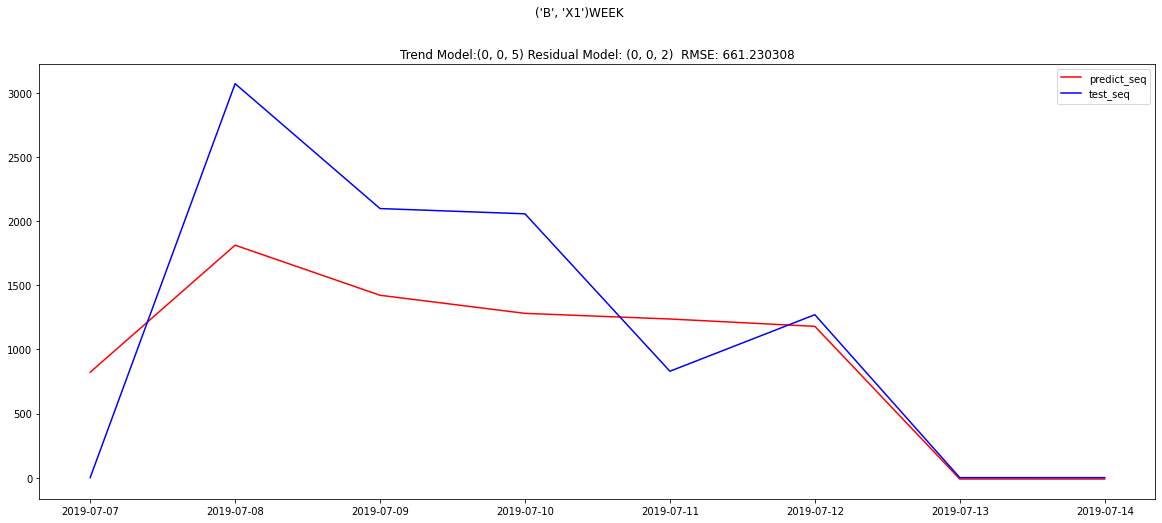

RMSE (0, 0, 0) 517.0001456755887
RMSE (0, 0, 1) 325.71254884460234
RMSE (0, 0, 0) 805.6732698469253
RMSE (0, 0, 1) 718.6545239504526
RMSE (0, 0, 2) 648.8516939664138
RMSE (0, 0, 3) 645.4272926138935
32


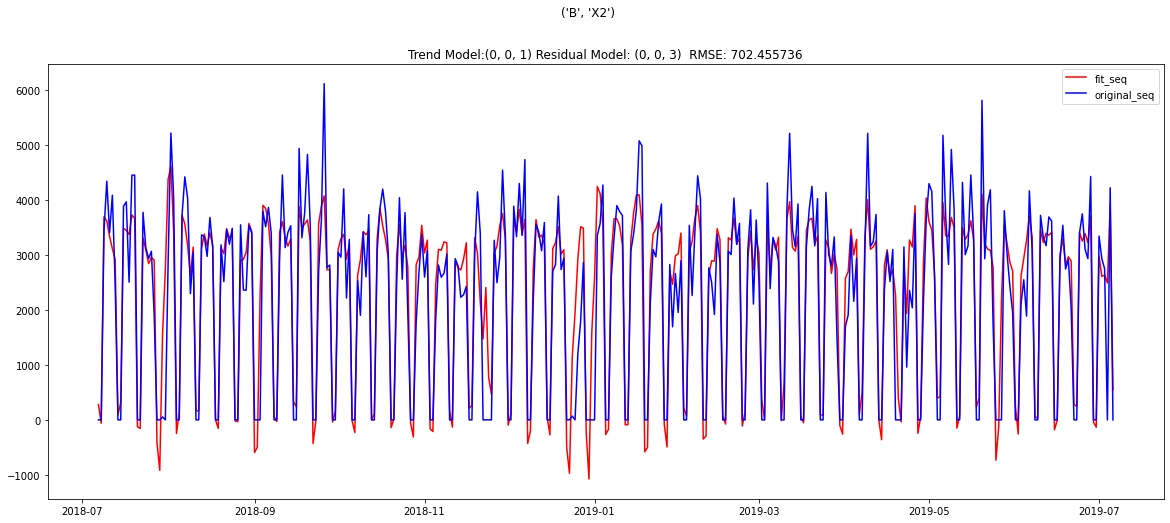

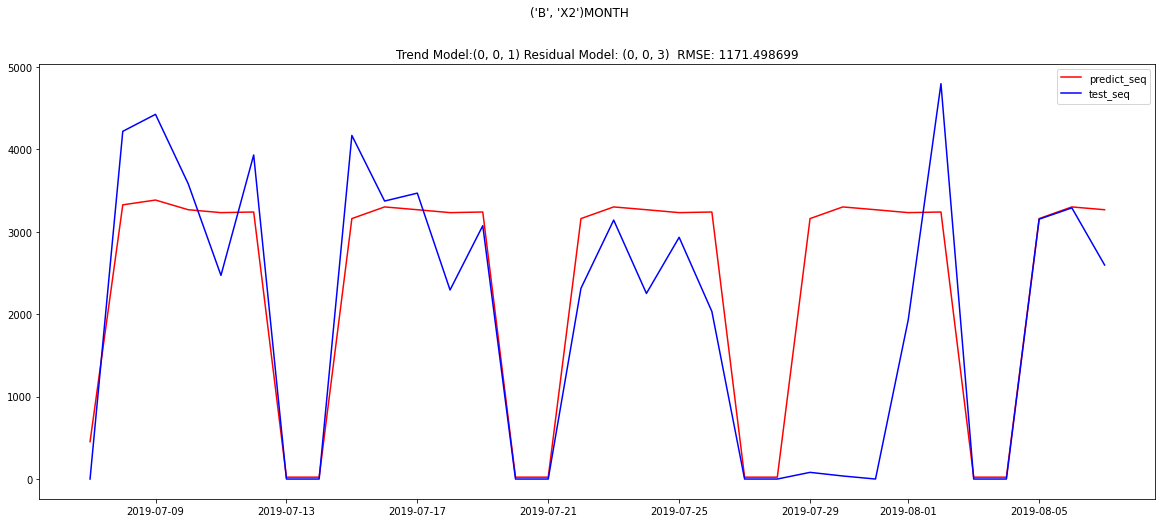

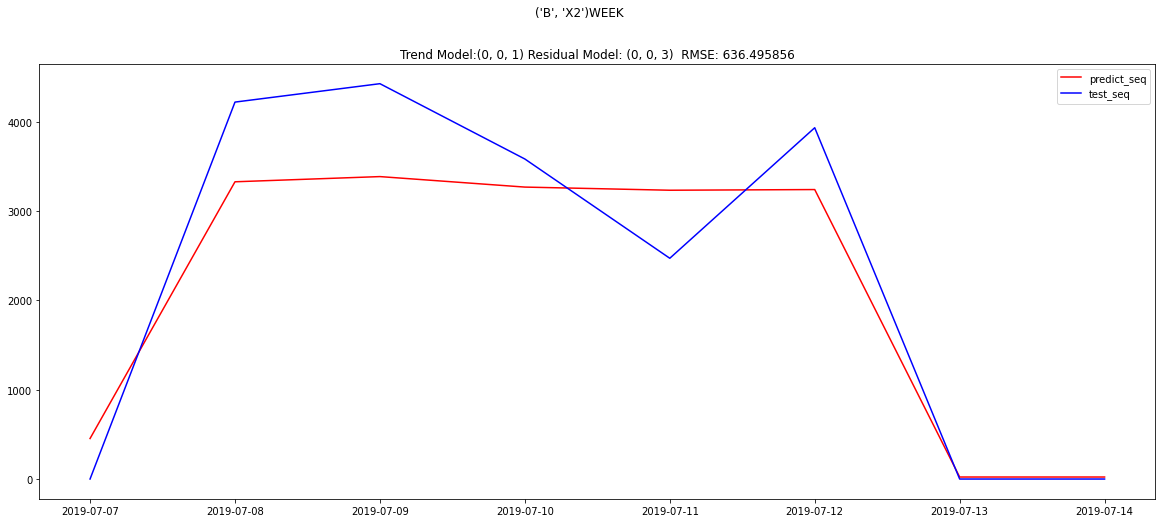

RMSE (0, 0, 0) 8.215534121006725
RMSE (0, 0, 1) 5.646157665898609
RMSE (0, 0, 3) 4.146949036616664
RMSE (0, 0, 5) 4.0962564646278805
RMSE (0, 0, 6) 2.9497790787383598
RMSE (0, 0, 7) 2.9453830084517936
RMSE (0, 0, 0) 18.811193179022997
RMSE (0, 0, 1) 15.680584035348609
RMSE (0, 0, 2) 14.780580975157365
32


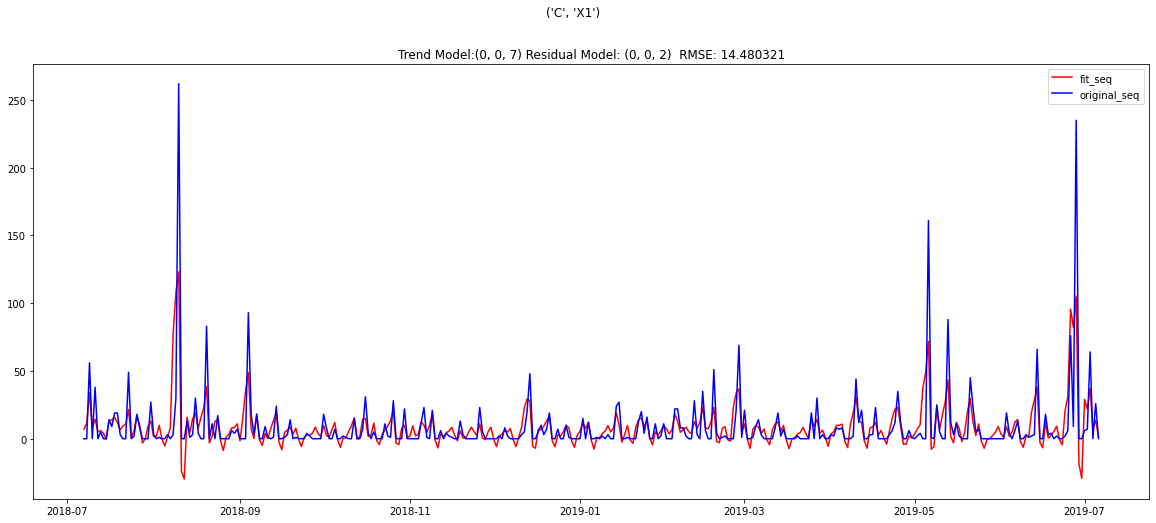

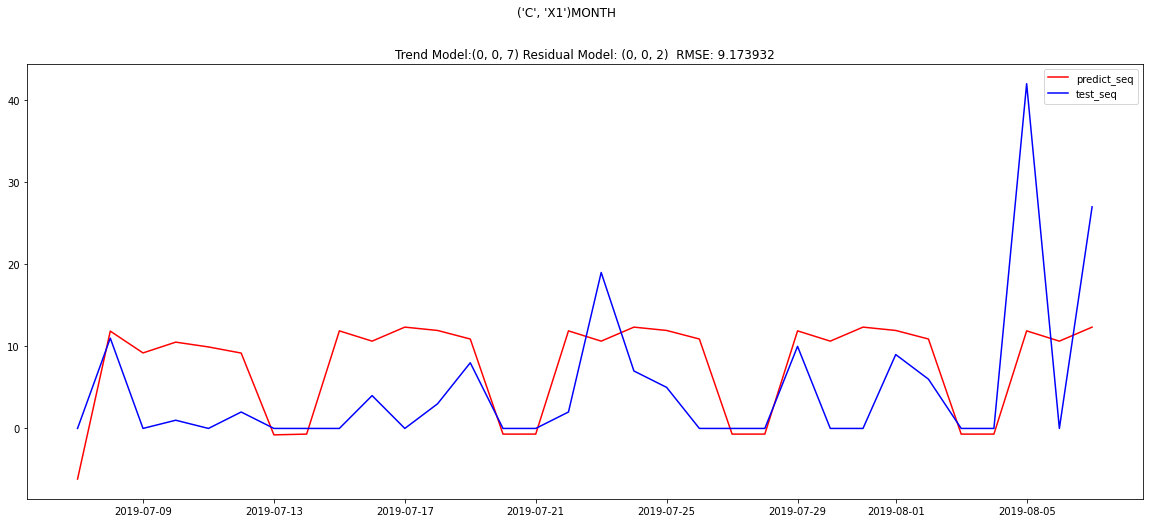

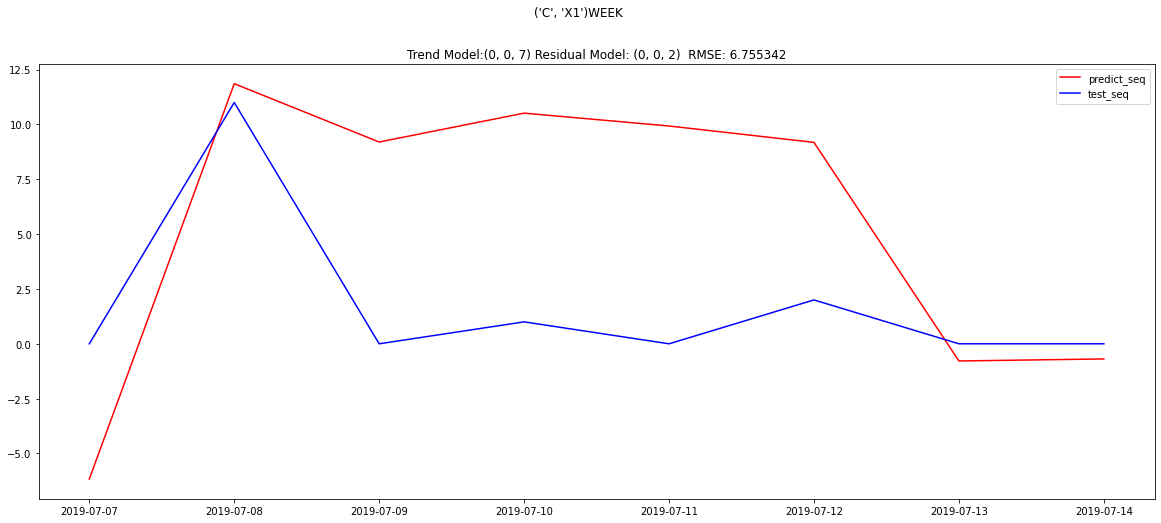

RMSE (0, 0, 0) 139.2413538691614
RMSE (0, 0, 1) 95.34271506654396
RMSE (0, 0, 3) 69.04391050439972
RMSE (0, 0, 4) 69.04375734050684
RMSE (0, 0, 5) 68.92543251204823
RMSE (0, 0, 6) 50.64877873237377
RMSE (0, 0, 7) 50.61988881001117
RMSE (0, 0, 0) 317.9260044327554
RMSE (0, 0, 1) 262.82965593499404
RMSE (0, 0, 2) 248.9655938068527
32


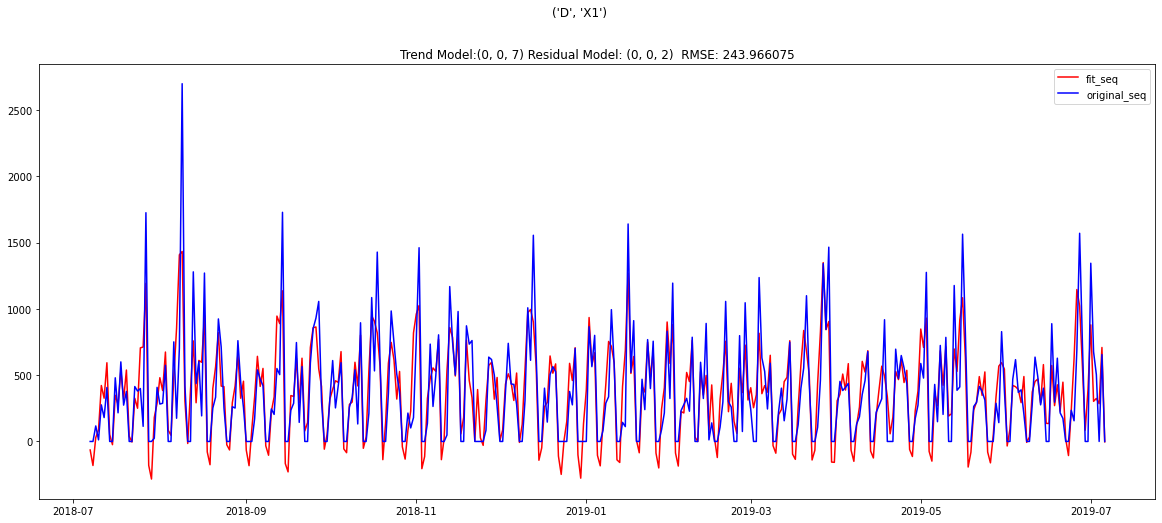

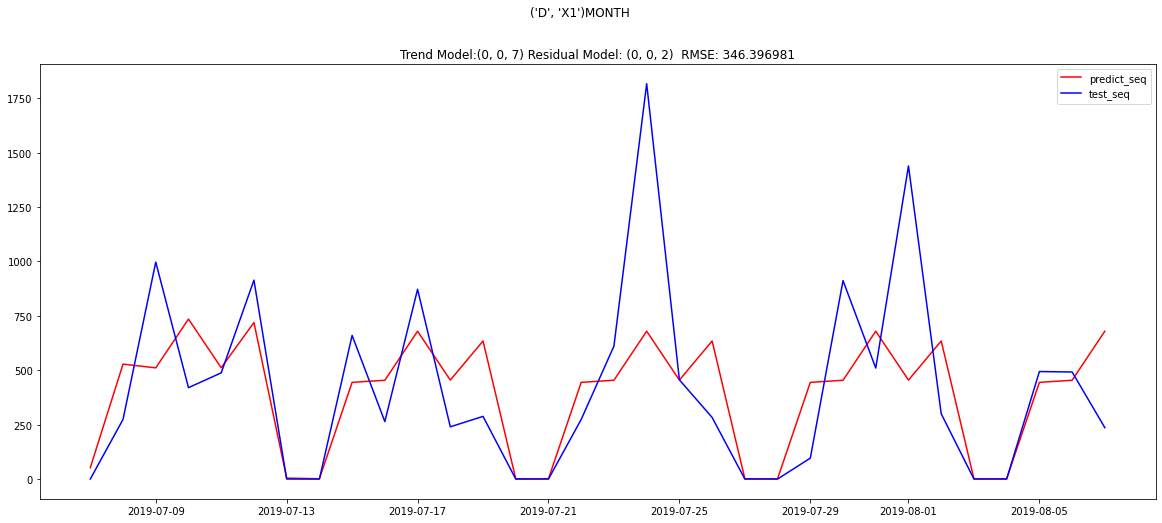

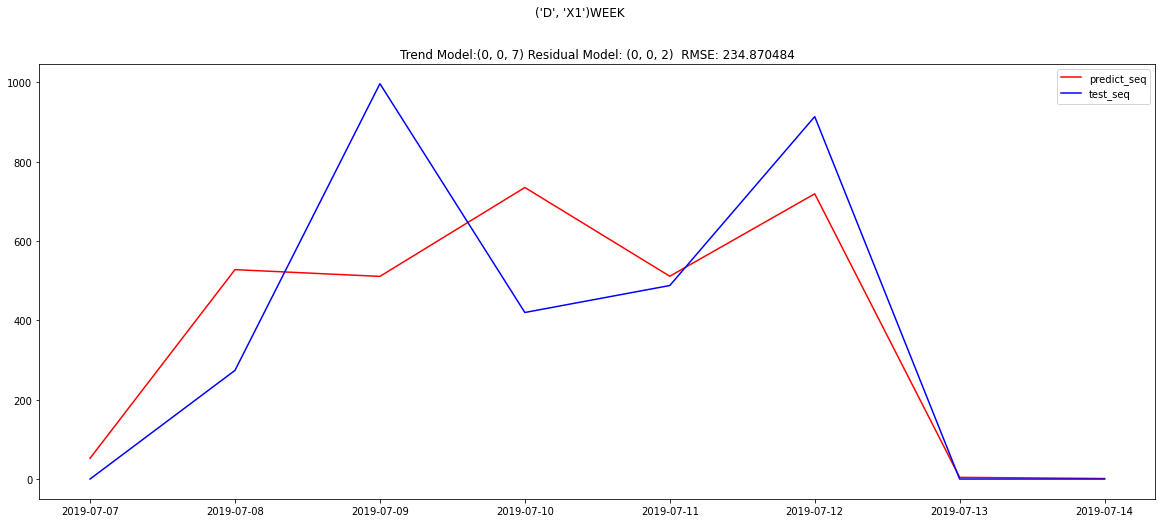

RMSE (0, 0, 0) 2161.6246079641332
RMSE (0, 0, 1) 1423.823666947124
RMSE (0, 0, 3) 988.8433875037359
RMSE (0, 0, 5) 964.5896120971819
RMSE (0, 0, 7) 698.7483847098782
RMSE (0, 0, 0) 4543.479375844137
RMSE (0, 0, 1) 3742.0657522115735
RMSE (0, 0, 2) 3555.101424224613
32


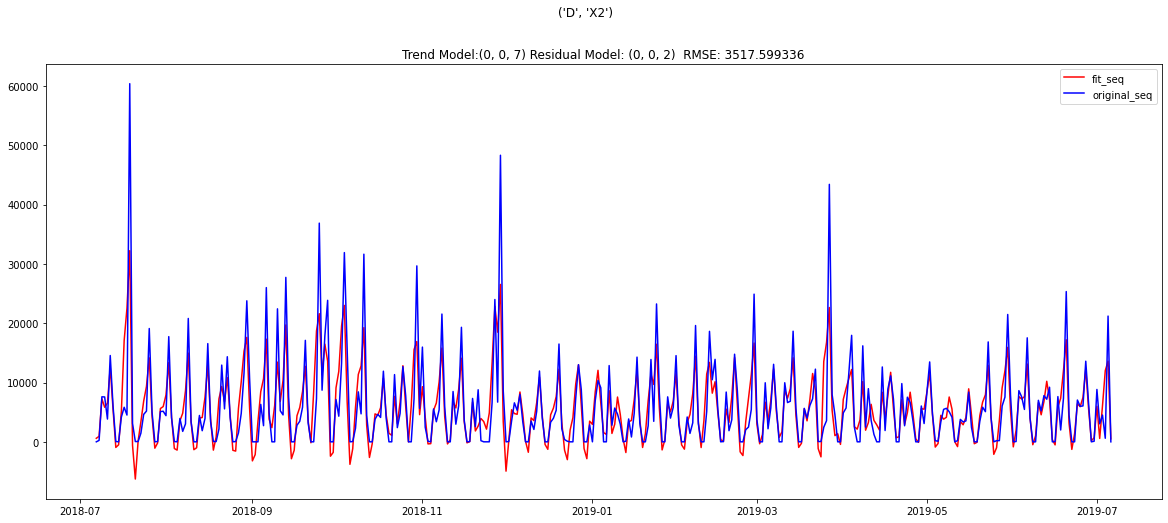

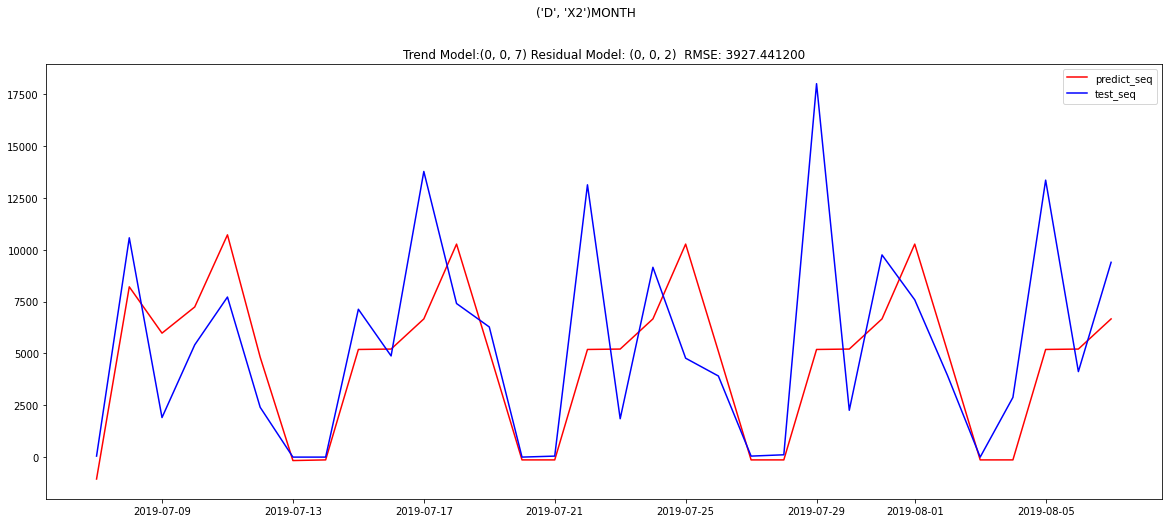

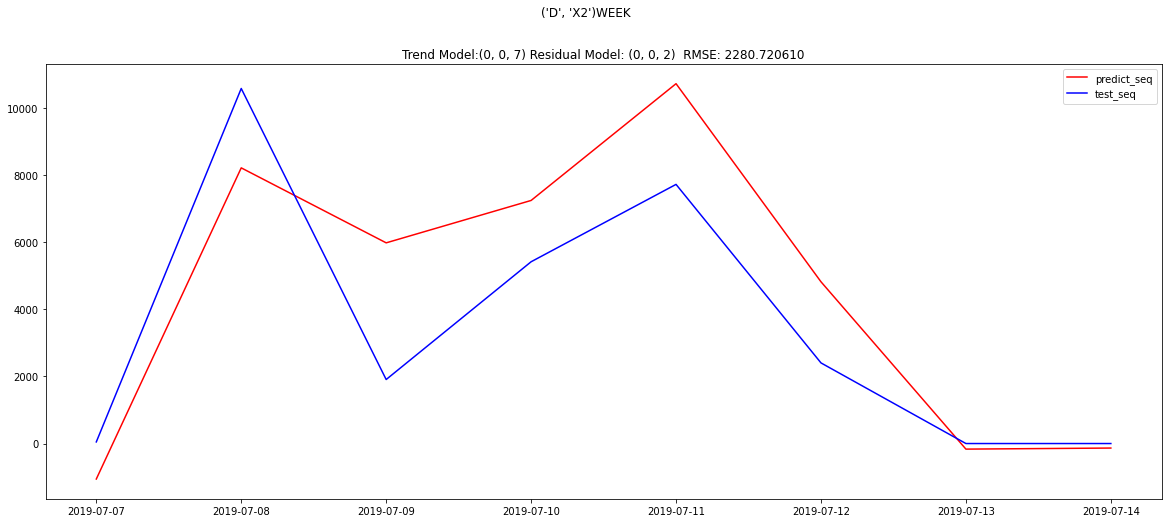

RMSE (0, 0, 0) 482.3587747263105
RMSE (0, 0, 1) 327.57889670569926
RMSE (0, 0, 3) 240.75374421205117
RMSE (0, 0, 5) 237.96673154558616
RMSE (0, 0, 7) 173.66748843571622
RMSE (0, 0, 0) 1070.0960959662905
RMSE (0, 0, 1) 891.3893790568404
RMSE (0, 0, 2) 842.2685160307304
RMSE (0, 0, 3) 842.2663532263809
32


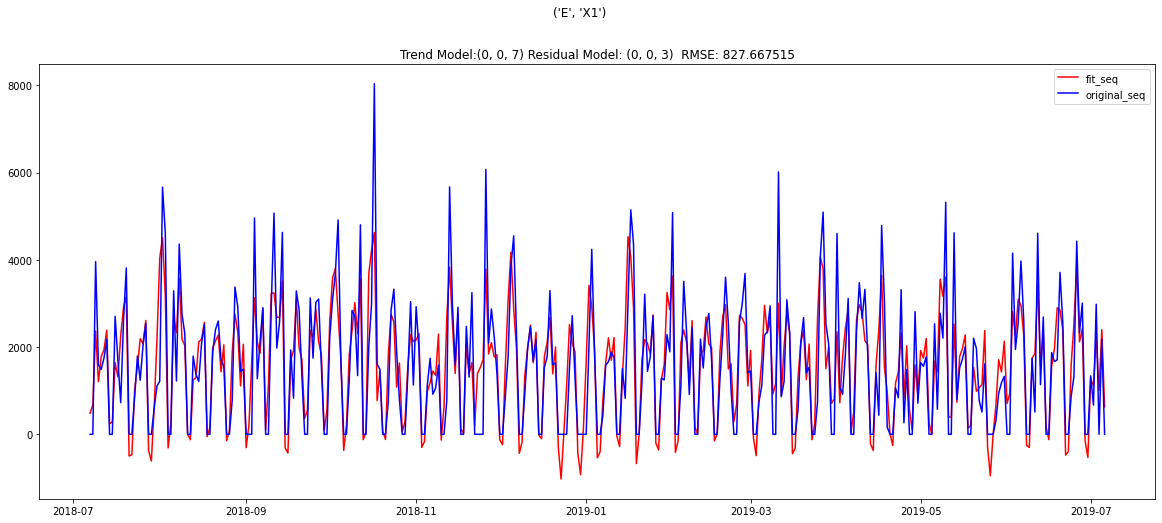

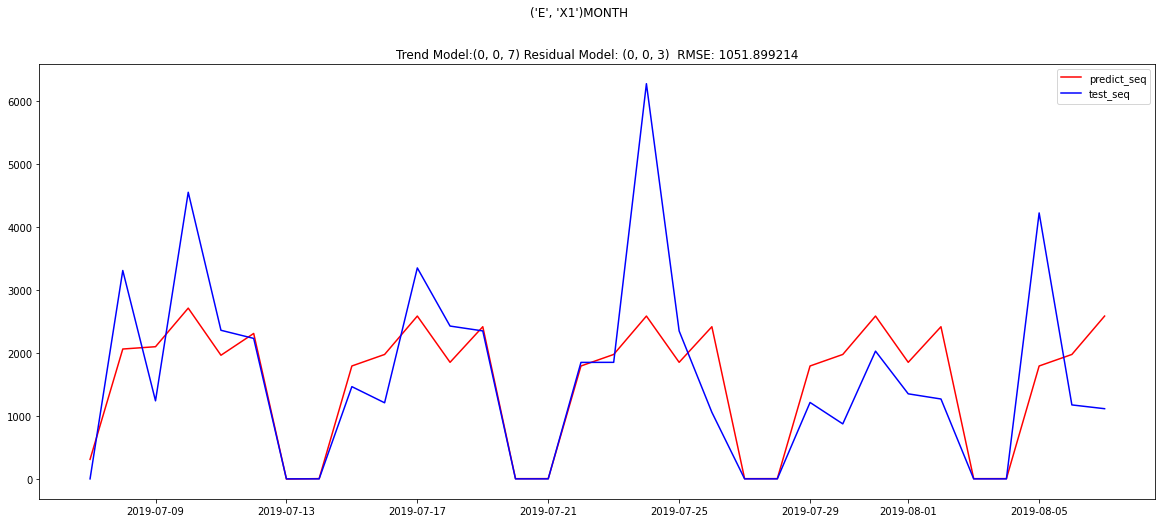

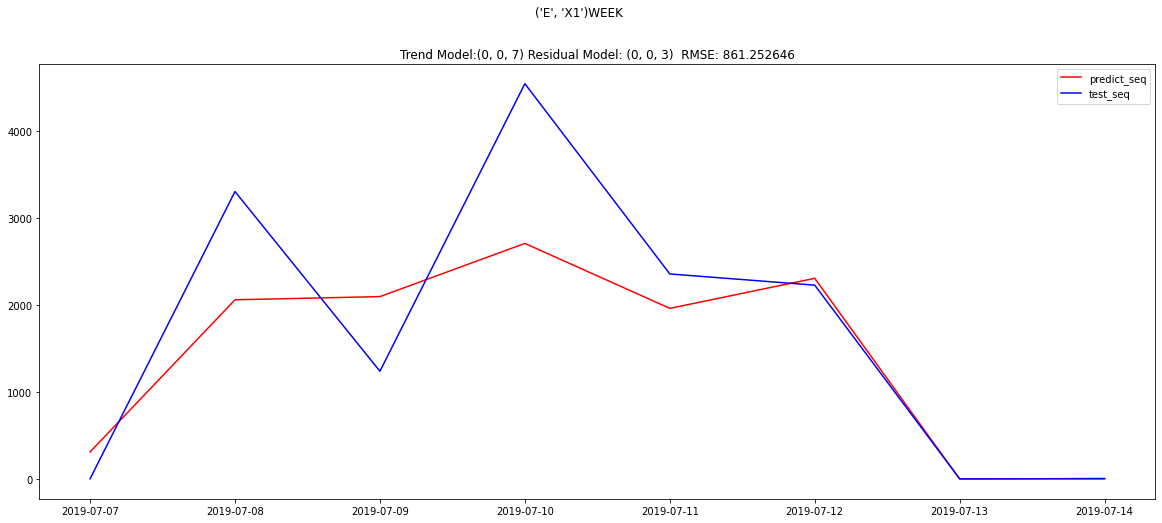

RMSE (0, 0, 0) 1852.6141674228631
RMSE (0, 0, 1) 1240.075896125327
RMSE (0, 0, 3) 876.7409709556856
RMSE (0, 0, 5) 873.817454680329
RMSE (0, 0, 7) 662.1663598967632
RMSE (0, 0, 0) 3863.873479580349
RMSE (0, 0, 1) 3314.2465753148654
RMSE (0, 0, 2) 3088.3615805891745
RMSE (0, 0, 3) 3083.1962068446605
32


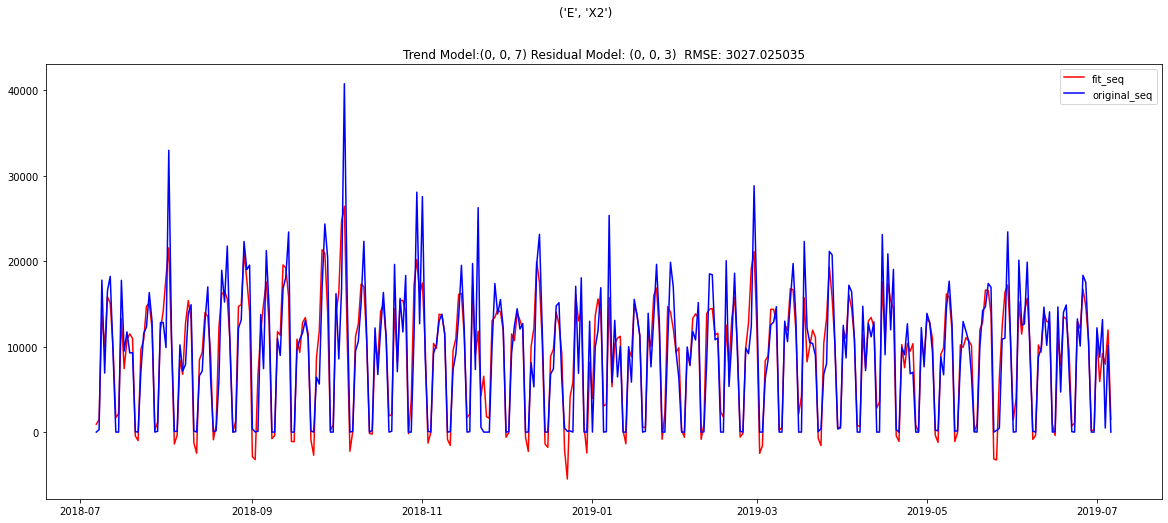

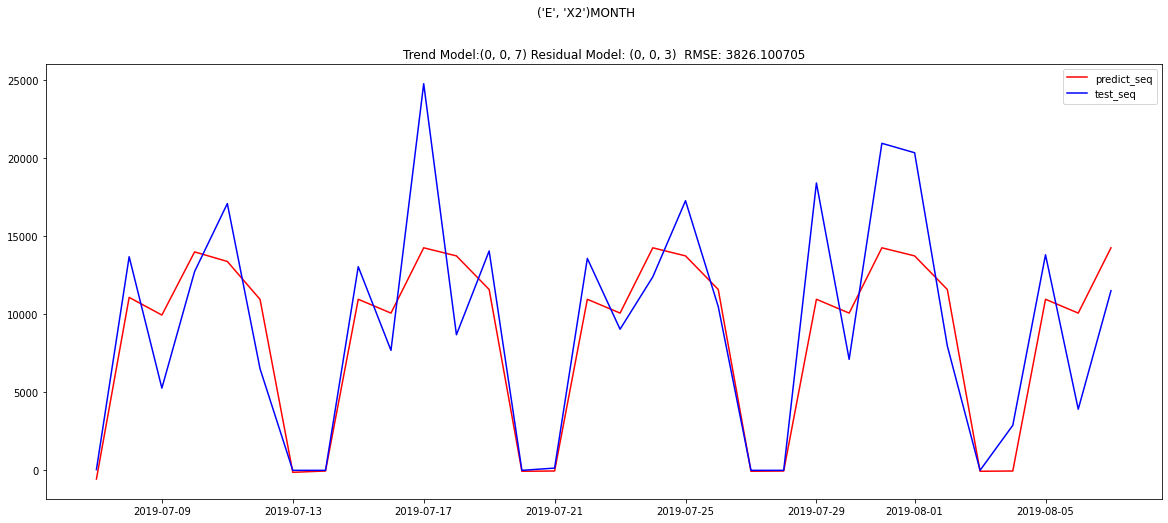

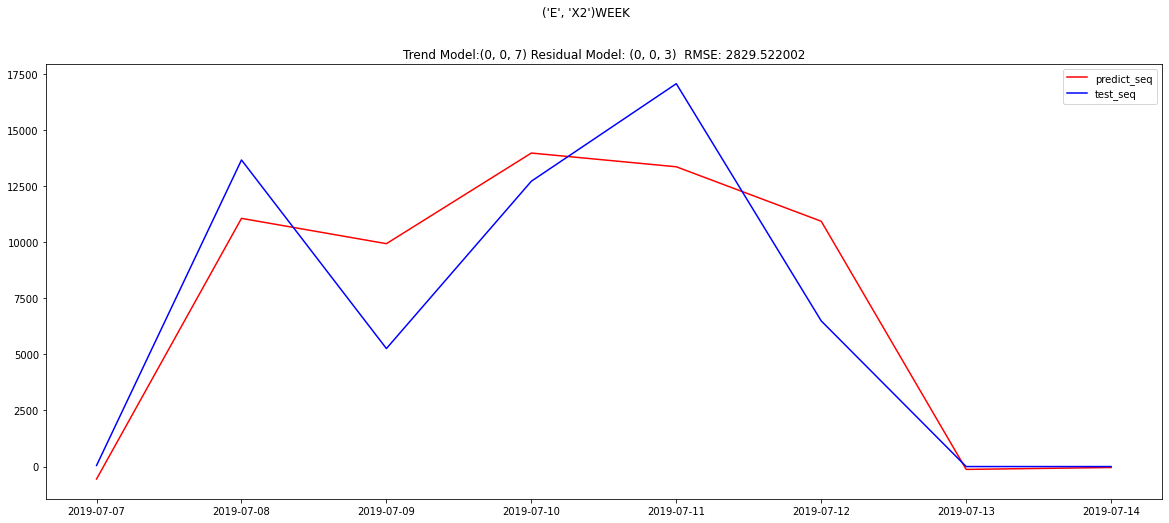

RMSE (0, 0, 0) 38.999354916228235
RMSE (0, 0, 1) 25.667691755657035
RMSE (0, 0, 3) 17.955771758597034
RMSE (0, 0, 5) 17.447017400849568
RMSE (0, 0, 7) 13.011225209351451
RMSE (0, 0, 0) 81.48851133469718
RMSE (0, 0, 1) 68.9479761928801
RMSE (0, 0, 2) 64.32892874184532
RMSE (0, 0, 3) 64.32782540023426
32


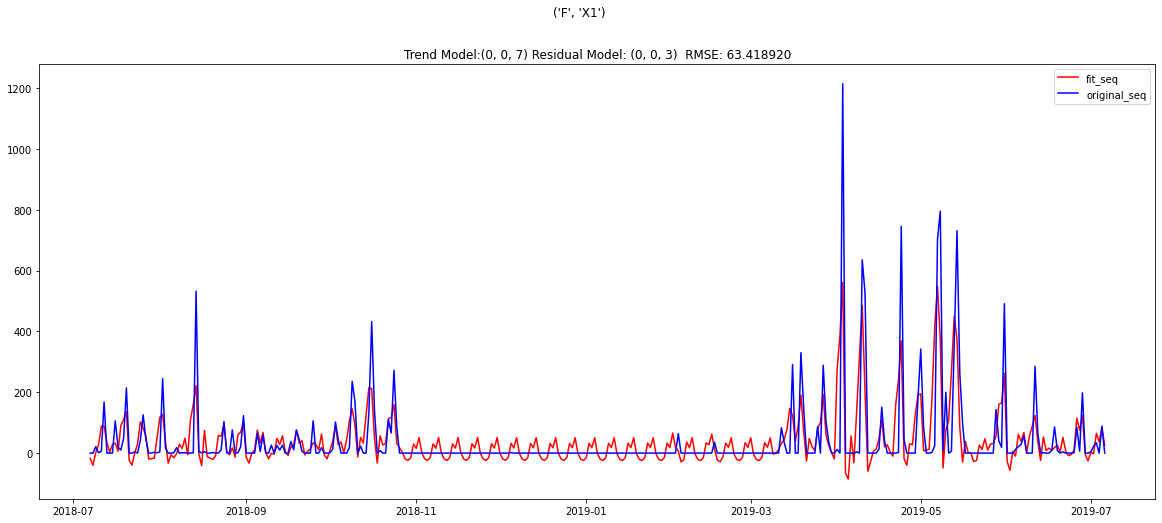

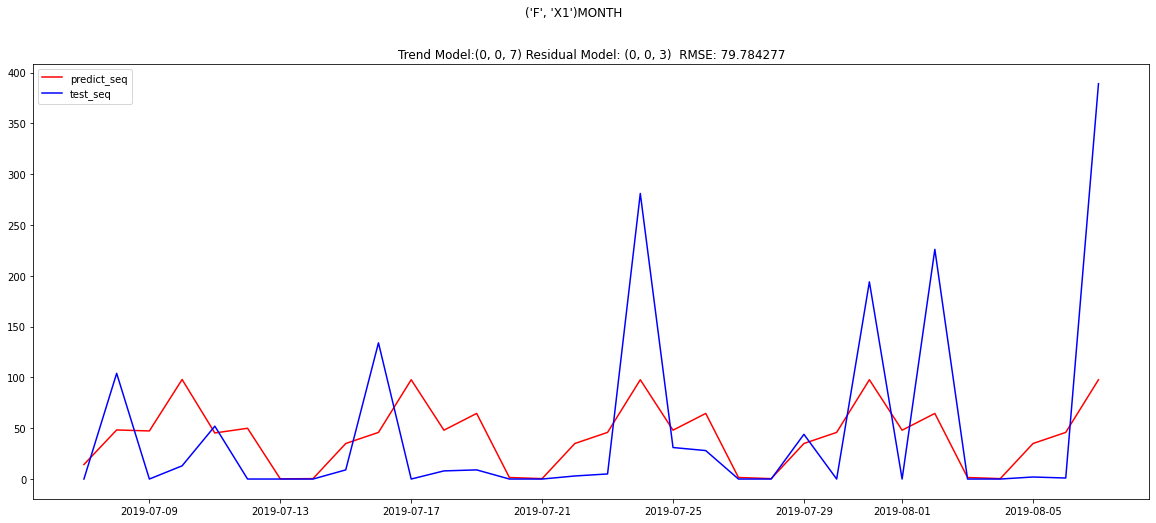

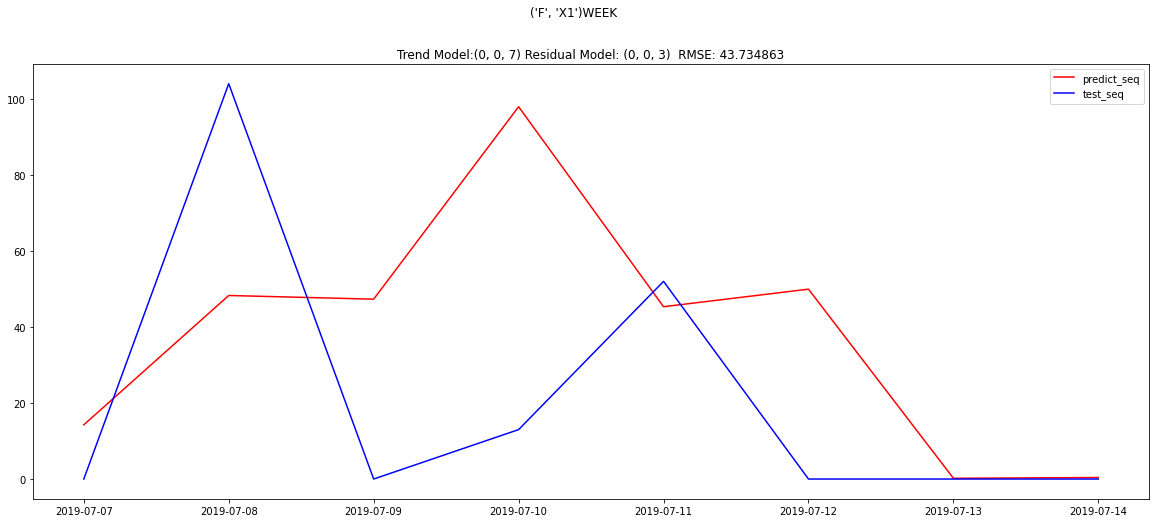

RMSE (0, 0, 0) 119.02839535981217
RMSE (0, 0, 1) 77.56123528284745
RMSE (0, 0, 5) 48.64072018890303
RMSE (0, 0, 0) 226.4056599980241
RMSE (0, 0, 1) 198.7202369625088
RMSE (0, 0, 2) 180.42913305622542
RMSE (0, 0, 3) 179.60779185848503
32


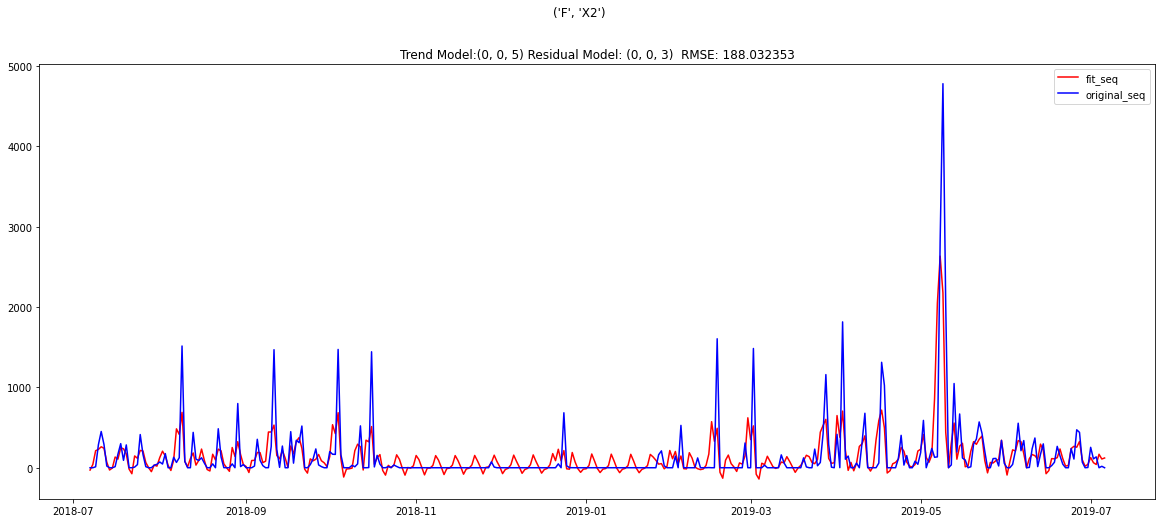

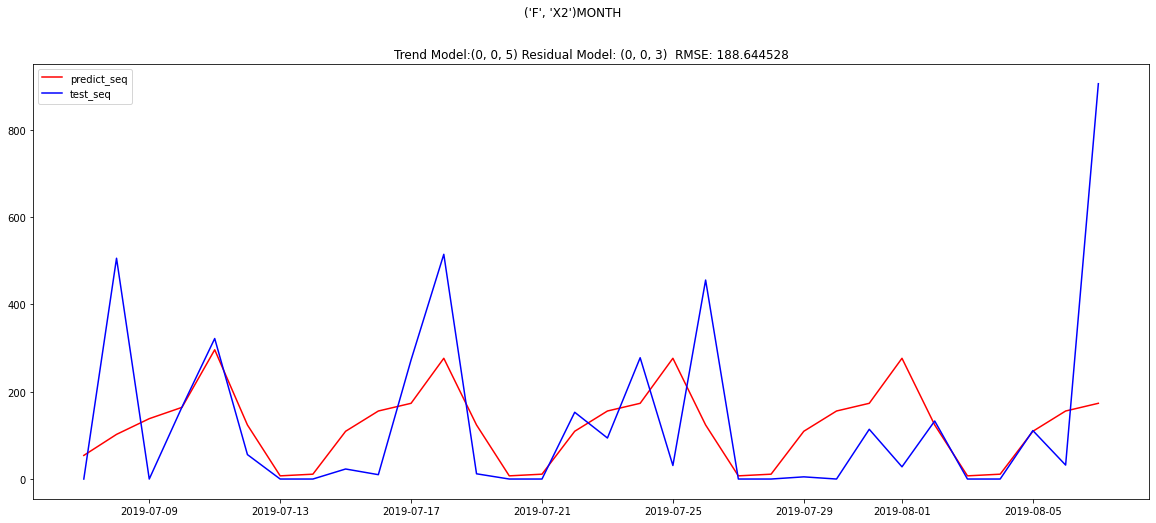

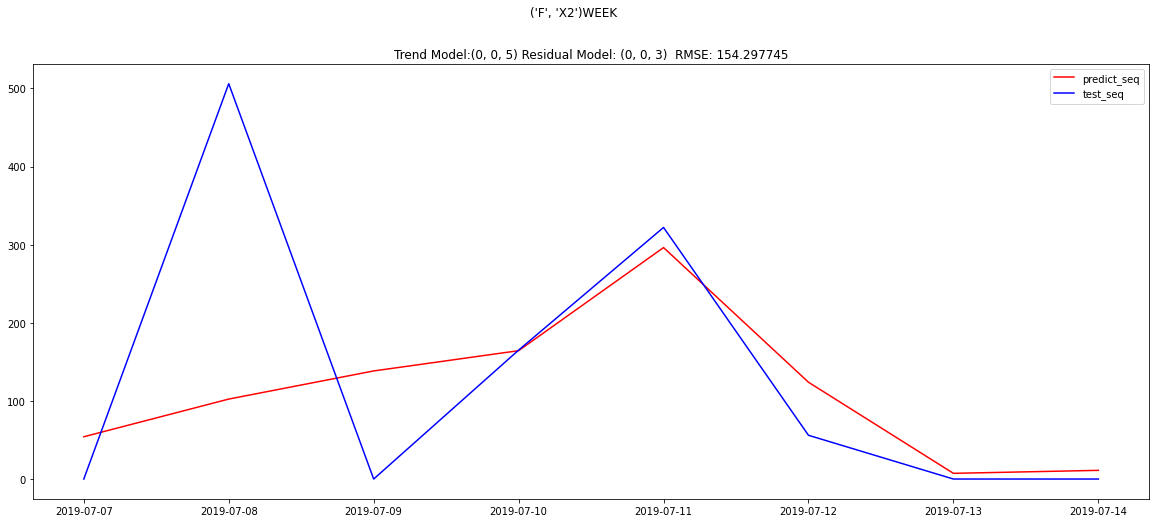

RMSE (0, 0, 0) 112.43410120546439
RMSE (0, 0, 1) 82.31731395588317
RMSE (0, 0, 2) 72.83678543215511
RMSE (0, 0, 3) 65.27340954989326
RMSE (0, 0, 4) 64.47188543083867
RMSE (0, 0, 5) 64.23002156983793
RMSE (0, 0, 6) 46.89196705227295
RMSE (0, 0, 7) 46.84309926178632
RMSE (0, 0, 0) 307.79619556224617
RMSE (0, 0, 1) 250.40269332898663
RMSE (0, 0, 2) 239.6463689156795
32


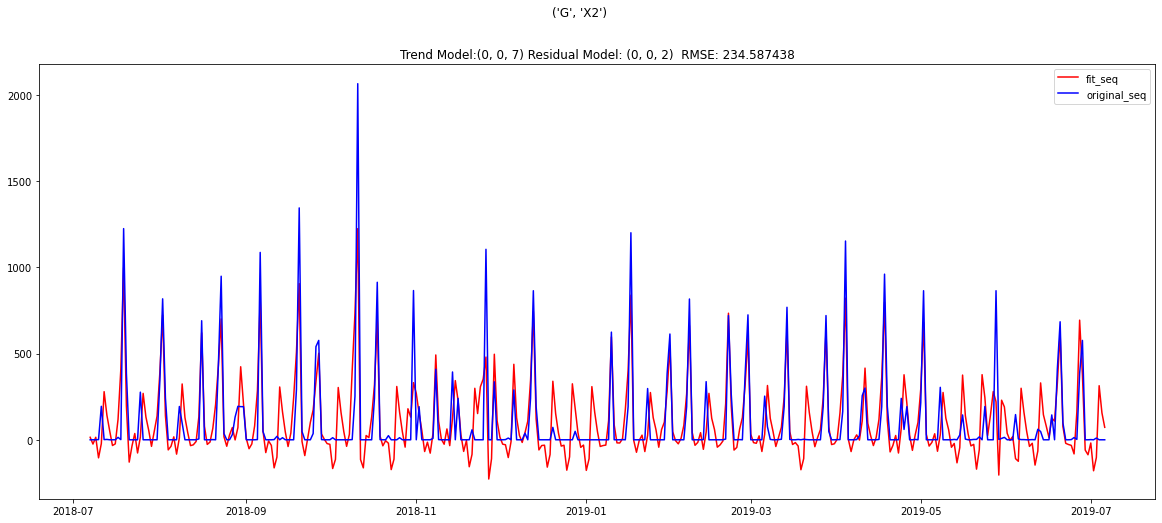

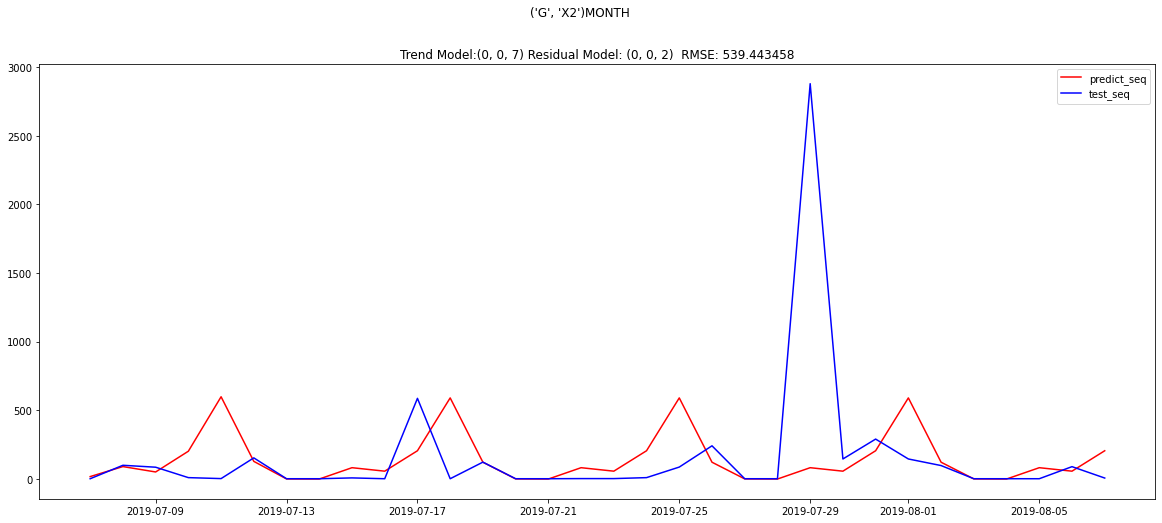

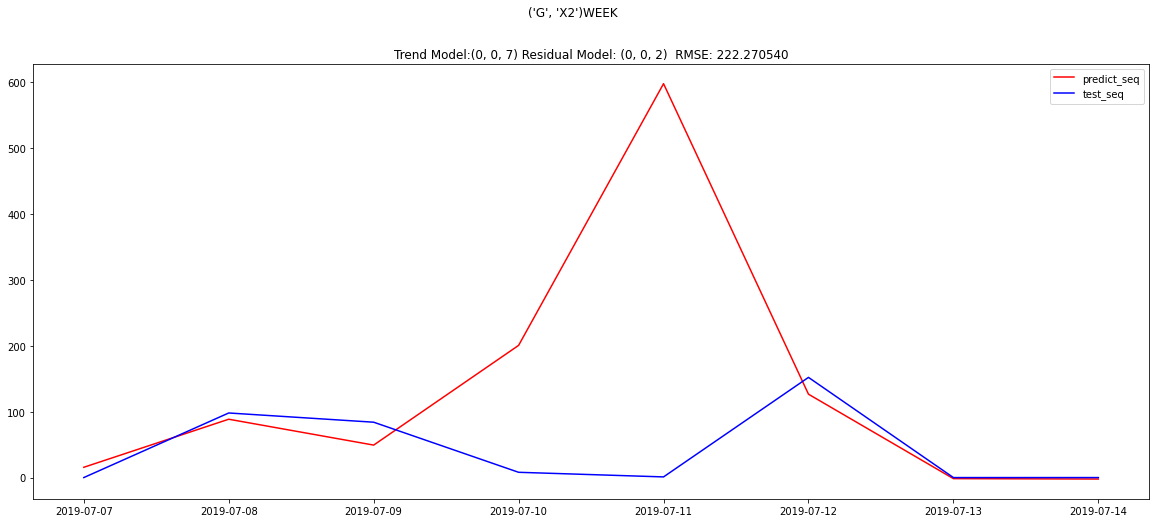

RMSE (0, 0, 0) 34.52511206053532
RMSE (0, 0, 1) 22.798751893689253
RMSE (0, 0, 3) 15.412998869634121
RMSE (0, 0, 5) 15.089904998674898
RMSE (0, 0, 6) 10.997942659739323
RMSE (0, 0, 7) 10.91143423510636
RMSE (0, 0, 0) 66.83051131065832
RMSE (0, 0, 1) 57.752973470492066
RMSE (0, 0, 2) 53.43358535228958
RMSE (0, 0, 3) 53.29241959622084
32


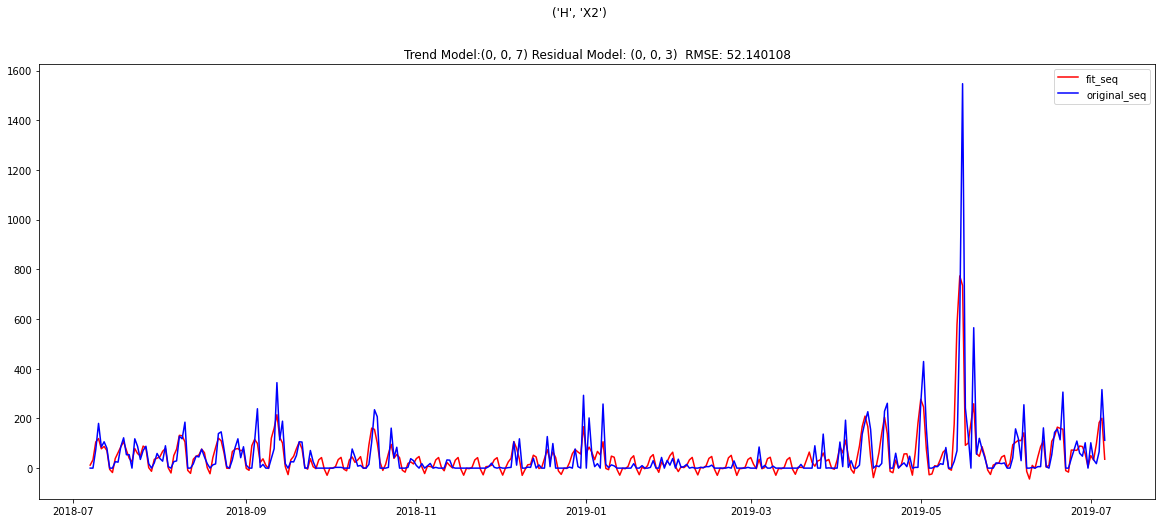

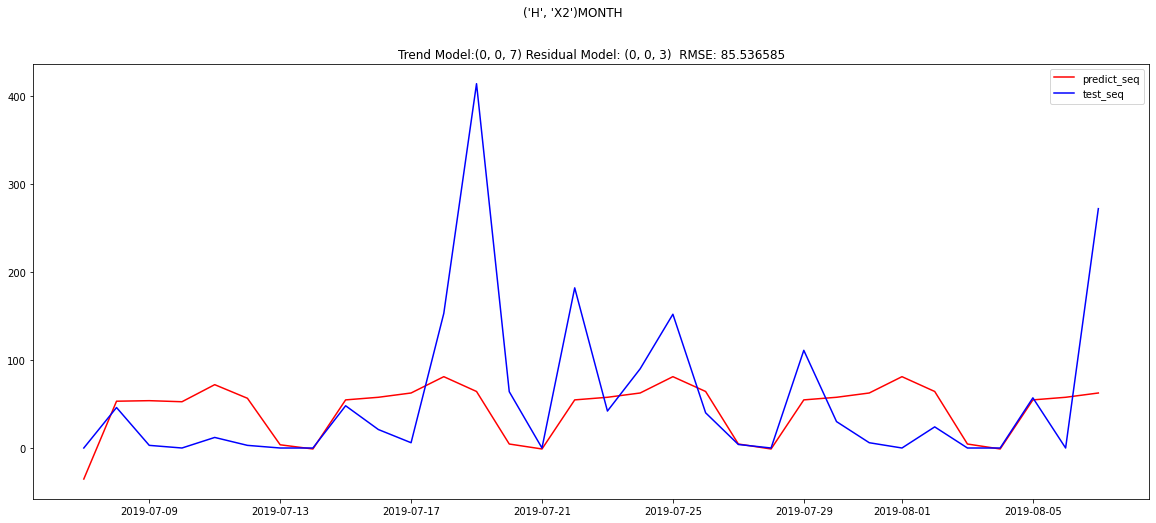

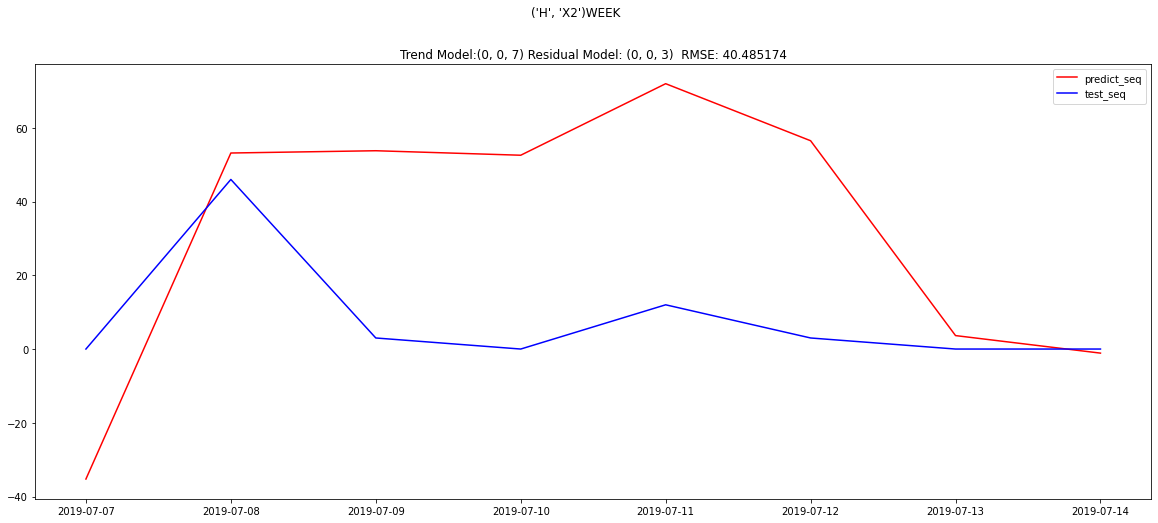

In [14]:
residual_pdq=list()
trend_pdq=list()
index=0
residual_pdq=list()
trend_pdq=list()
model_info=pd.DataFrame(columns=['Label','Trend','Residual','Simulation_RMSE','Month_RMSE','Week_RMSE','Simulation_WAPE','Month_WAPE','Week_WAPE'])
index=0

for label,df in groups:
  if index<0:
    print(label)
    pass
  else:
    train_size=int(len(df)*0.9)
    
    data=df.iloc[:,2].astype('int')
    #series=log(data)

    series=data
    series.index=data.index.astype('datetime64[ns]')
    train=series[0:train_size]
    test=series[train_size:]
 
    decomposition = seasonal_decompose(series)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    trend = trend.fillna(0)
    seasonal = seasonal.fillna(0)
    residual = residual.fillna(0)

    tr_pdq=gridsearch_MA(trend)
    re_pdq=gridsearch_MA(residual)

    trend_pdq.append(tr_pdq)
    residual_pdq.append(re_pdq)
    
    fit_seq,pre_seq=model_fit(seasonal,trend,residual,tr_pdq,re_pdq)
    
    #recover the log sequence
    #fit_seq=recover(fit_seq)
    #pre_seq=recover(pre_seq)

    rs,ws=fit_plot(fit_seq,label,data[0:train_size],tr_pdq,re_pdq)
    rm,wm=pre_month(pre_seq,label,data[train_size:],tr_pdq,re_pdq)
    rw,ww=pre_week(pre_seq[0:8],label,data[train_size:],tr_pdq,re_pdq)

    model_info.loc[index]=[label,tr_pdq,re_pdq,rs,rm,rw,ws,wm,ww]

    

  index+=1

In [15]:
model_info.to_csv('/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/Model_info/ARIMA.csv')

In [16]:
data1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/Model_info/ARIMA.csv')
data1

,Unnamed: 0,Label,Trend,Residual,Simulation_RMSE,Month_RMSE,Week_RMSE,Simulation_WAPE,Month_WAPE,Week_WAPE
0,0,"('A', 'X1')","(0, 0, 7)","(0, 0, 2)",109.532368,178.535618,193.973101,0.524362,0.608370,0.789863
1,1,"('A', 'X2')","(0, 0, 3)","(0, 0, 2)",1214.111061,980.340763,916.010399,0.648476,0.535321,0.840389
2,2,"('B', 'X1')","(0, 0, 5)","(0, 0, 2)",521.115135,676.968015,661.230308,0.344228,0.416102,0.434525
3,3,"('B', 'X2')","(0, 0, 1)","(0, 0, 3)",702.455736,1171.498699,636.495856,0.209634,0.368193,0.225356
4,4,"('C', 'X1')","(0, 0, 7)","(0, 0, 2)",14.480321,9.173932,6.755342,0.941615,1.414584,3.165376
5,5,"('D', 'X1')","(0, 0, 7)","(0, 0, 2)",243.966075,346.396981,234.870484,0.437919,0.535502,0.430418
6,6,"('D', 'X2')","(0, 0, 7)","(0, 0, 2)",3517.599336,3927.441200,2280.720610,0.470802,0.509515,0.537449
7,7,"('E', 'X1')","(0, 0, 7)","(0, 0, 3)",827.667515,1051.899214,861.252646,0.381578,0.422154,0.346045
8,8,"('E', 'X2')","(0, 0, 7)","(0, 0, 3)",3027.025035,3826.100705,2829.522002,0.243046,0.315477,0.315858
9,9,"('F', 'X1')","(0, 0, 7)","(0, 0, 3)",63.418920,79.784277,43.734863,0.923059,1.051659,1.535230


In [17]:
#model_info.to_csv('/content/drive/MyDrive/Colab Notebooks/LSE/Capstone/Model_info/ARIMA_value.csv')

# Process Date

In [18]:
date=series.index

In [19]:
date[1]

Timestamp('2015-01-06 00:00:00')

In [20]:
date[7].weekday()+1

1

In [21]:
date=pd.DataFrame(columns=['DATE','Workday'])
date['DATE']=series.index

In [22]:
def weekday(row):
  #row[1]=row[0].weekday()+1
  print(row)

In [23]:
df=pd.read_csv("/content/drive/MyDrive/Data/US Holiday Dates (2004-2021).csv")
holiday=df['Date']
holiday.head(20)


0     2004-07-04
1     2005-07-04
2     2006-07-04
3     2007-07-04
4     2008-07-04
5     2009-07-04
6     2010-07-04
7     2011-07-04
8     2012-07-04
9     2013-07-04
10    2014-07-04
11    2015-07-04
12    2016-07-04
13    2017-07-04
14    2018-07-04
15    2019-07-04
16    2020-07-04
17    2021-07-04
18    2004-12-25
19    2005-12-25
Name: Date, dtype: object

In [24]:

for i in range(0,len(series.index)):
  if (date['DATE'][i].weekday()+1)>5:
    date['Workday'][i]=0
  else:
    date['Workday'][i]=1
date.head(14)

,DATE,Workday
0,2015-01-05,1
1,2015-01-06,1
2,2015-01-07,1
3,2015-01-08,1
4,2015-01-09,1
5,2015-01-10,0
6,2015-01-11,0
7,2015-01-12,1
8,2015-01-13,1
9,2015-01-14,1


In [25]:
for i in range(0,len(series.index)):
  for j in range(0,len(holiday)):
    if date['DATE'][i]==holiday[j]:

      date['Workday'][i]=0
date


,DATE,Workday
0,2015-01-05,1
1,2015-01-06,1
2,2015-01-07,1
3,2015-01-08,1
4,2015-01-09,1
...,...,...
1822,2020-01-01,1
1823,2020-01-02,1
1824,2020-01-03,1
1825,2020-01-04,0


In [26]:
holiday[1]

'2005-07-04'

In [27]:
holiday=holiday.astype('datetime64[ns]')

In [28]:
type(holiday[1])

pandas._libs.tslibs.timestamps.Timestamp

In [29]:
date.set_index('DATE',inplace=True)

In [30]:
date

,Workday
DATE,
2015-01-05,1
2015-01-06,1
2015-01-07,1
2015-01-08,1
2015-01-09,1
...,...
2020-01-01,1
2020-01-02,1
2020-01-03,1


In [31]:
date.to_csv('/content/drive/MyDrive/Data/workday.csv')